## DAC: Deep Autoencoder-based Clustering, a General Deep Learning Framework of Representation Learning

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
import random

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

mnist_train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
print(mnist_train_data)
print(mnist_test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [12]:
train_loader = DataLoader(dataset=mnist_train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=mnist_test_data, batch_size=64, shuffle=True)

In [7]:
# Pick 1000 samples for weight calculation in loss fucntion
num_samples = 1000
subset, _ = random_split(mnist_train_data, [num_samples, len(mnist_train_data) - num_samples])
sample_loader = DataLoader(dataset=subset, batch_size=num_samples, shuffle=False)

## AUTOENCODER
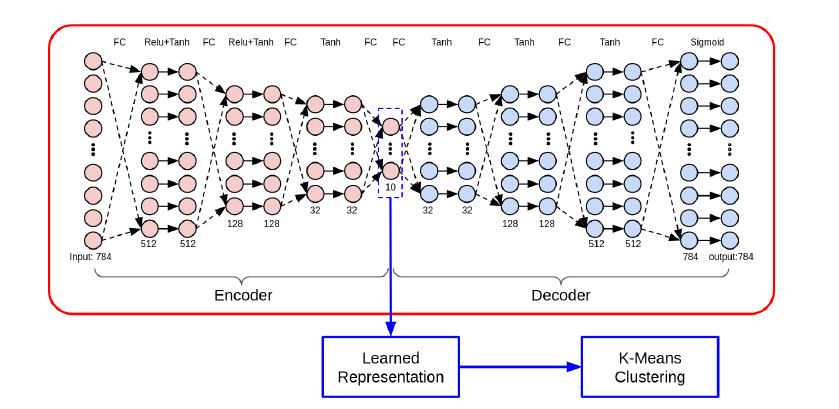

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Tanh(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Tanh(),
            nn.Linear(32, 10)
        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 32),
            nn.Tanh(),
            nn.Linear(32, 128),
            nn.Tanh(),
            nn.Linear(128, 512),
            nn.Tanh(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Clustering-weighted MSE Loss
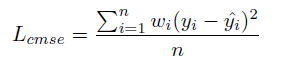
<br>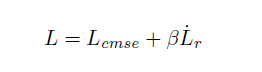

In [9]:
class CustomWeightedMSELoss(nn.Module):
    def __init__(self, weights, weight_decay=0.0):
        super(CustomWeightedMSELoss, self).__init__()
        self.weights = weights
        self.weight_decay = weight_decay

    def forward(self, input, target, model):
        squared_diff = ((input - target)**2) * (self.weights)
        reconstruction_loss = torch.mean(squared_diff) * 1000
        l2_regularization = 0.0
        for param in model.parameters():
            if param.requires_grad:
                l2_regularization += torch.sum(param ** 2)

        total_loss = reconstruction_loss + 0.5 * self.weight_decay * l2_regularization
        return total_loss 

## Feature Weights
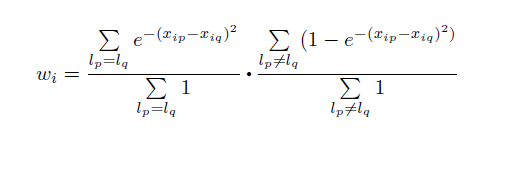

In [10]:
class CustomWeights(nn.Module):
    def __init__(self, images, labels):
        super(CustomWeights, self).__init__()
        self.images = images
        self.labels = labels

    def weightsCoefficient(self):
        within_class_diff = self.within_class_difference()
        between_class_diff = self.between_class_difference()
        return within_class_diff * between_class_diff


    def within_class_difference(self):
        images = self.images.reshape(-1, 28*28)
        wcd = torch.zeros((1 , images.size(1)))
        for i in range(images.size(1)):
            feature = images[:, i]
            within_class_diff = 0
            n  = 0
            unique_labels = torch.unique(self.labels)

            for label in unique_labels:
                same_class_samples = feature[self.labels == label]
                same_class_samples_count = same_class_samples.size(0)

                pairwise_diff = same_class_samples.view(-1, 1) - same_class_samples.view(1, -1)
                weighted_exponential = torch.exp(-(pairwise_diff ** 2))
                within_class_diff += torch.sum(weighted_exponential)
                n +=  (same_class_samples_count * same_class_samples_count) - same_class_samples_count

            wcd[0, i] = within_class_diff / n
        return wcd


    def between_class_difference(self):
          images = self.images.reshape(-1, 28*28)
          bcd = torch.zeros(1, images.size(1))
          for i in range(images.size(1)):
              feature = images[:, i]
              between_class_diff = 0
              n = 0
              unique_labels = torch.unique(self.labels)

              for label1 in unique_labels:
                  for label2 in unique_labels:
                      if label1 != label2:
                          class1_samples = feature[self.labels == label1]
                          class2_samples = feature[self.labels == label2]
                          n += class1_samples.size(0) * class2_samples.size(0)
                          pairwise_diff = class1_samples.view(-1, 1) - class2_samples.view(1, -1)
                          weighted_exponential = 1 - torch.exp(-(pairwise_diff ** 2))
                          between_class_diff += torch.sum(weighted_exponential)

              bcd[0, i] = between_class_diff / n
          return bcd

In [11]:
for images, labels in sample_loader:
  wc = CustomWeights(images, labels)
  wi = wc.weightsCoefficient()

A map of the clustering weight computed for MNIST dataset using 1000 samples from
the training set. It could be seen that pixels at boundaries and corners are less important than the
ones around image centers.

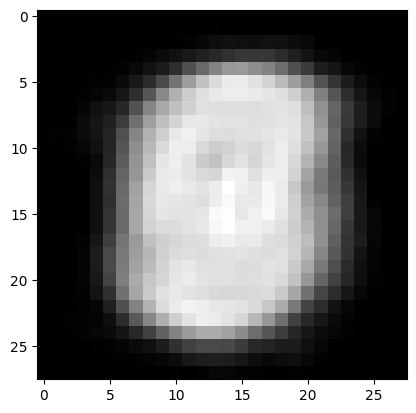

In [9]:
wi_ = wi.view(-1, 28 , 28)
plt.imshow(wi_[0], cmap="gray")

In [12]:
model = Autoencoder()
weight_decay = 1e-5
criterion = CustomWeightedMSELoss(wi, weight_decay)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 200
outputs = []
for epoch in range(num_epochs):
    for (img, _) in train_loader:
        img = img.reshape(-1, 28*28)
        recon = model(img)
        loss = criterion(recon, img, model)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    outputs.append((epoch, img, recon))

Sample results of our trained autoencoder on MNIST dataset. Top: raw input images.
Bottom: reconstructed images

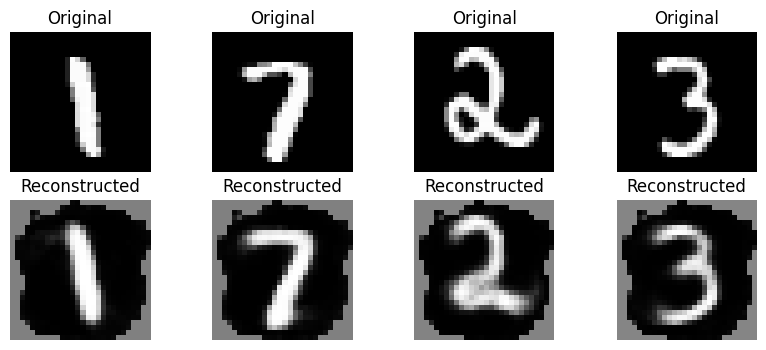

In [14]:
num_images_to_display = 4
min_value = 0
max_value = len(outputs)
random_data = [random.randint(min_value, max_value) for _ in range(num_images_to_display)]
fig, axs = plt.subplots(2, num_images_to_display, figsize=(10, 4))

images = []
recons = []
for _, img, reco in outputs:
   images.append(img.view(-1, 28 , 28))
   recons.append(reco.reshape(-1, 28 , 28).detach().numpy())

for num in range(num_images_to_display):
            axs[0, num].imshow(images[random_data[num]][num], cmap='gray')
            axs[0, num].axis('off')
            axs[0, num].set_title('Original')

            axs[1, num].imshow(recons[random_data[num]][num], cmap='gray')
            axs[1, num].axis('off')
            axs[1, num].set_title('Reconstructed')
plt.show()

K_Means

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import numpy as np

In [16]:
# Collect encoded features from the test dataset
model.eval()
encoded_features = []
test_images = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28)
        test_labels.append(labels)
        test_images.append(images)
        encoded = model.encoder(images)
        encoded_features.append(encoded)

encoded_features = torch.cat(encoded_features, dim=0).numpy()
test_labels = torch.cat(test_labels, dim=0).numpy()
test_images = torch.cat(test_images, dim=0).numpy()

K_Means with the output of the encoder (learned representations)

In [17]:
n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
kmeans.fit(encoded_features)

predicted_labels = kmeans.labels_

ari1 = adjusted_rand_score(test_labels, predicted_labels)

print(f'Adjusted Rand Index (ARI): {ari1}')

Adjusted Rand Index (ARI): 0.6193695597533716


K_Means with test images

In [18]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
kmeans.fit(test_images)

predicted_labels = kmeans.labels_

ari2 = adjusted_rand_score(test_labels, predicted_labels)

print(f'Adjusted Rand Index (ARI): {ari2}')

Adjusted Rand Index (ARI): 0.3830896074246391


Comparing results from our implementation with those from the paper

In [29]:
from tabulate import tabulate

table = [[" ", "K-Mesn", "DAC"], ["ARI from Our Impplemetation", round(ari2, 4), round(ari1, 4)],
         ["ARI from Paper", 0.3477 , 0.6624]]
print(tabulate(table, tablefmt="fancy_grid"))

╒═════════════════════════════╤════════╤════════╕
│                             │ K-Mesn │ DAC    │
├─────────────────────────────┼────────┼────────┤
│ ARI from Our Impplemetation │ 0.3831 │ 0.6194 │
├─────────────────────────────┼────────┼────────┤
│ ARI from Paper              │ 0.3477 │ 0.6624 │
╘═════════════════════════════╧════════╧════════╛
